# NPZ model and synthetic (model-generated) observations

 * Nutrient-Phytoplankton-Zooplankton (NPZ) models are commonly used in oceanographic research to simulate nutrient cycling at the bottom of the food web.
 * While more complex NPZ model formulations simulate different nutrients and hundreds of plankton variables, and are often coupled to physical circulation models, here we focus on a basic NPZ model with 3 variables:

<img src="images/npz_diagram_sun.png" alt="NPZ diagramm" width="600"/>

 * The 4 pathways in this model (growth, grazing, $P$ mortality, and $Z$ mortality) are described by mathematical equations that are goverened by rate parameters (all parameters contain $\theta$ in their name):
$$
\begin{alignat*}{3}
	\text{growth:}      \quad & \theta_\texttt{vmax}\;\frac{N}{N+\theta_\texttt{nuthalfsat}}\;P \nonumber \\
	\text{grazing:}     \quad & \theta_\texttt{graz}\;P\;Z \nonumber \\
	P\text{ mortality:} \quad & \theta_\texttt{mort\_p}\;P \nonumber \\
	Z\text{ mortality:} \quad & \theta_\texttt{mort\_z}\;Z^{2} \nonumber \\
\end{alignat*}
$$
   The variables $N$, $P$, and $Z$ denote the amount (concentration) of nutrients, phytoplankton and zooplankton in the model, respectively.
 * Together, the above equations are used to create a system of ordinary differential equations (ODEs) which describe the model dynamics and are included in the Python code below.
$$
\begin{alignat*}{5}
	\frac{\partial{}N}{\partial{}t} &=& -\theta_\texttt{vmax}\;\frac{N}{N+\theta_\texttt{nuthalfsat}}\;P &\;&        &\;& +\theta_\texttt{mort\_p}\;P &\;& +\theta_\texttt{mort\_z}\;Z^{2} \nonumber \\
	\frac{\partial{}P}{\partial{}t} &=&  \theta_\texttt{vmax}\;\frac{N}{N+\theta_\texttt{nuthalfsat}}\;P &\;& -\theta_\texttt{graz}\;P\;Z &\;& -\theta_\texttt{mort\_p}\;P &\;& \nonumber \\
	\frac{\partial{}Z}{\partial{}t} &=& &\;&  \theta_\texttt{graz}\;P\;Z &\;& &\;& -\theta_\texttt{mort\_z}\;Z^{2} \nonumber 
\end{alignat*}
$$

### Adding light

 * Modulate phytoplankton growth by annual light cycle (modeled to roughly represent day length in the northern hemisphere, with a minimum on Dec 21):
<img src="images/npz_lightparam.png" alt="NPZ light parametrization" width="600"/>
 * The full $P$ growth term becomes: $\theta_\texttt{vmax} \left(1 + 0.5\cdot\left(\theta_\texttt{irr} \cdot \sin\left(\frac{2\pi}{365} (t-81.25)\right)-\theta_\texttt{irr}\right)\right) \frac{N}{N+\theta_\texttt{nuthalfsat}} P$
 * The model now contains parameters in total: $\theta_\texttt{vmax}, \theta_\texttt{nuthalfsat}, \theta_\texttt{graz}, \theta_\texttt{mort_p}, \theta_\texttt{mort_z}$ and $\theta_\texttt{irr}$

## some preparation: 
create a Python version of the NPZ model

In [1]:
#%matplotlib notebook
import numpy as np

# specify parameter values, these are used as reference parameters to generate synthetic data
theta = {
    'vmax':0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat':0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz':0.02,        # zooplankton grazing rate
    'mort_p':0.02,      # phytoplankton mortality rate
    'mort_z':0.03,      # zooplankton mortality rate
    'irr':0.8,          # light amplitude
}

# specify model 
def npz(x,t,theta):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    theta: model parameters
    '''
    n = max(x[0], 0.0)
    p = max(x[1], 0.0)
    z = max(x[2], 0.0)
    
    light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])
    growth = theta['vmax']*n/(theta['nuthalfsat']+n) * light * p
    grazing = theta['graz'] * p*z
    ploss = theta['mort_p'] * p
    zloss = theta['mort_z'] * z*z
    return np.array((-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss))

run the model using an ODE solver

In [2]:
from scipy.integrate import odeint

# initial conditions
x0 = np.array((0.6,0.15,0.25))

# initialize time vector
t = np.arange(0.0,2*365.0,1.0)

x = odeint(npz, x0, t, args=(theta,))

plot the model output

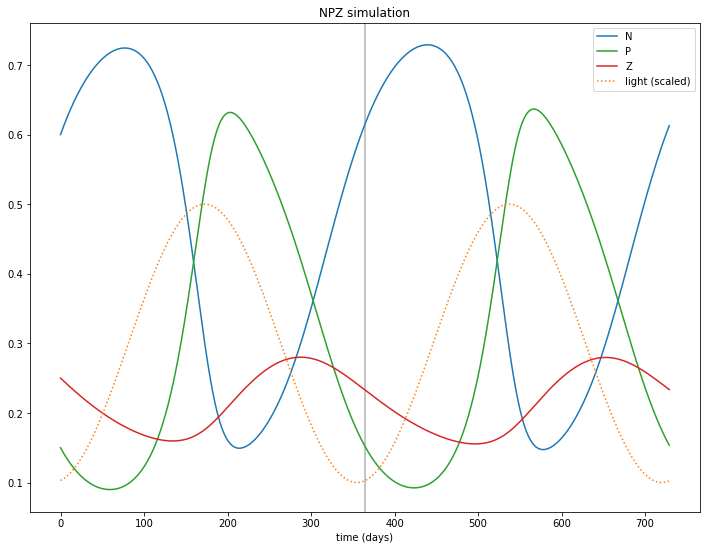

In [3]:
colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ simulation', xlabel='time (days)')
ax.legend()
None

sample from one of the parameters randomly and plot the resulting output 

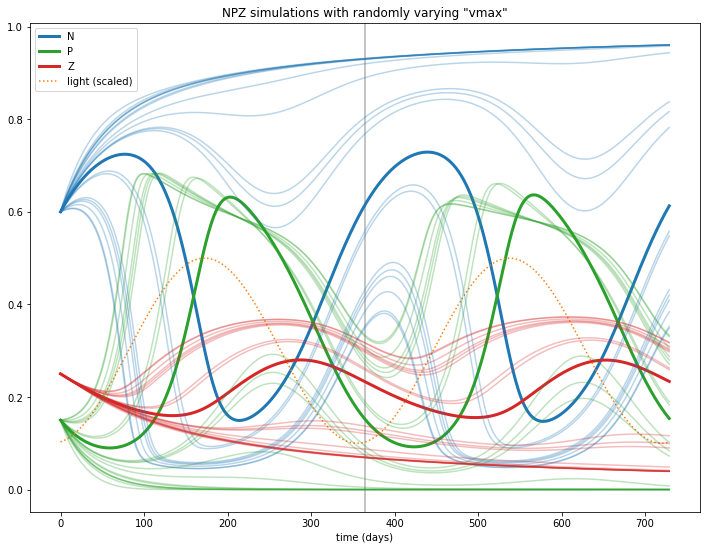

In [4]:
fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], linewidth=3, label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')

theta_rand = theta.copy()
for isample in range(20):
    theta_rand['vmax'] = np.random.normal(loc=0.1, scale=0.1)
    x_rand = odeint(npz, x0, t, args=(theta_rand,))
    for i,name in enumerate(('N','P','Z')):
        ax.plot(t,x_rand[:,i], color=colors[i], alpha=0.3)
ax.set(title='NPZ simulations with randomly varying "vmax"', xlabel='time (days)')
ax.legend()
None

<div class="alert alert-block alert-info">
<b>Exercise:</b> Now, treat the initial conditions as uncertain and draw the initial conditions for one of the 3 variables from a distribution of your choice (be aware that negative initial conditions may lead to odd model behavior). Plot the model output for different initial conditions.
</div>

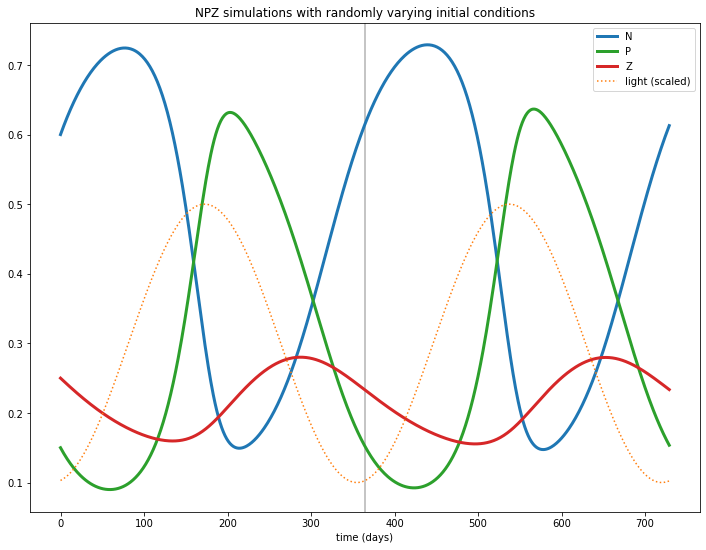

In [5]:
fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], linewidth=3, label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ simulations with randomly varying initial conditions', xlabel='time (days)')
ax.legend()

#
# add code here
#

generate synthetic observations and save them to file

In [6]:
iobs = np.random.choice(len(t)//10-1, 20, replace=False)*10 + 1 # do not allow zeros
iobs.sort()

# the observation error for each obervation type N,P,Z
sigma = np.array([0.03,0.03,0.03])

tobs = t[iobs]
obs = np.maximum(0.0, x[iobs,:] + np.random.normal(size=(iobs.size,3))*sigma)

# write obs to file
np.savetxt('../data/data_npz_synthetic.csv', np.concatenate((tobs[:,None],obs), axis=1), delimiter=',', header='time,N,P,Z')

plot data with observations

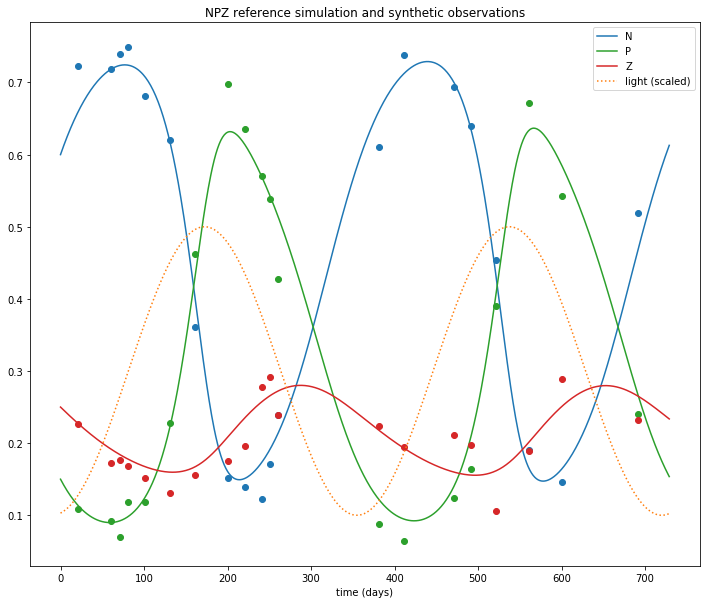

In [7]:
colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,10))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
    ax.plot(tobs, obs[:,i], color=colors[i], marker='o', ls='none')
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ reference simulation and synthetic observations', xlabel='time (days)')
ax.legend()
None